In [2]:
import sys
sys.path.append('../')
from src.mess_ai.features.extractor import FeatureExtractor
import matplotlib.pyplot as plt

In [3]:
# Test Feature Extraction with MERT
import numpy as np
import torch
import time
import os
from pathlib import Path
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

print("=== Environment Check ===")
print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Determine best device
if torch.backends.mps.is_available():
    device = "mps"
    print(f"🚀 Using Apple Silicon MPS acceleration")
elif torch.cuda.is_available():
    device = "cuda"
    print(f"🚀 Using CUDA device: {torch.cuda.get_device_name()}")
else:
    device = "cpu"
    print("⚠️  Using CPU (consider GPU acceleration)")

# Check if transformers is installed
try:
    import transformers
    print(f"Transformers version: {transformers.__version__}")
except ImportError:
    print("⚠️  Transformers not installed. Run: pip install transformers>=4.38")

# Check SMD data availability
smd_dir = Path("../data/smd/wav-44")
audio_files = list(smd_dir.glob("*.wav")) if smd_dir.exists() else []
print(f"Found {len(audio_files)} audio files in SMD dataset")

=== Environment Check ===
PyTorch version: 2.6.0
MPS available: True
CUDA available: False
🚀 Using Apple Silicon MPS acceleration
Transformers version: 4.51.3
Found 50 audio files in SMD dataset


In [4]:
# Initialize Feature Extractor
print("\n=== Initializing MERT Feature Extractor ===")

try:
    # Force reload the module to pick up MPS changes
    import importlib
    import src.mess_ai.features.extractor as extractor_module
    importlib.reload(extractor_module)
    from src.mess_ai.features.extractor import FeatureExtractor
    
    start_time = time.time()
    extractor = FeatureExtractor()
    load_time = time.time() - start_time
    print(f"✅ MERT model loaded successfully in {load_time:.2f} seconds")
    print(f"Model device: {extractor.device}")
    print(f"Target sample rate: {extractor.target_sample_rate}Hz")
    print(f"Segment duration: {extractor.segment_duration}s")
    
    if extractor.device == 'mps':
        print("🚀 Using Apple Silicon MPS acceleration!")
    elif extractor.device == 'cpu':
        print("⚠️  Using CPU - check if MPS is available but incompatible with MERT")
    
except Exception as e:
    print(f"❌ Failed to load MERT model: {e}")
    print("Make sure transformers is installed: pip install transformers>=4.38")
    import traceback
    traceback.print_exc()

INFO:root:Loading MERT model: m-a-p/MERT-v1-95M



=== Initializing MERT Feature Extractor ===


INFO:root:MERT model loaded successfully on mps


✅ MERT model loaded successfully in 1.47 seconds
Model device: mps
Target sample rate: 24000Hz
Segment duration: 5.0s
🚀 Using Apple Silicon MPS acceleration!


In [5]:
# Test Single File Feature Extraction
print("\n=== Single File Test ===")

if audio_files:
    # Use first Bach file for testing
    test_file = audio_files[0]
    print(f"Testing with: {test_file.name}")
    
    try:
        # Extract features without saving
        start_time = time.time()
        features = extractor.extract_track_features(test_file)
        extract_time = time.time() - start_time
        
        print(f"✅ Feature extraction completed in {extract_time:.2f} seconds")
        
        # Analyze feature dimensions
        print(f"\nFeature Shapes:")
        print(f"Raw features: {features['raw'].shape}")
        print(f"Segment features: {features['segments'].shape}")  
        print(f"Aggregated features: {features['aggregated'].shape}")
        
        # Memory usage estimate
        raw_size_mb = features['raw'].nbytes / (1024**2)
        print(f"\nMemory usage for raw features: {raw_size_mb:.2f} MB")
        
    except Exception as e:
        print(f"❌ Feature extraction failed: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("⚠️  No audio files found. Check data/smd/wav-44/ directory")

INFO:root:Extracting features for: ../data/smd/wav-44/Chopin_Op028-17_005_20100611-SMD.wav



=== Single File Test ===
Testing with: Chopin_Op028-17_005_20100611-SMD.wav
✅ Feature extraction completed in 3.95 seconds

Feature Shapes:
Raw features: (70, 13, 374, 768)
Segment features: (70, 13, 768)
Aggregated features: (13, 768)

Memory usage for raw features: 997.09 MB



=== Feature Analysis ===


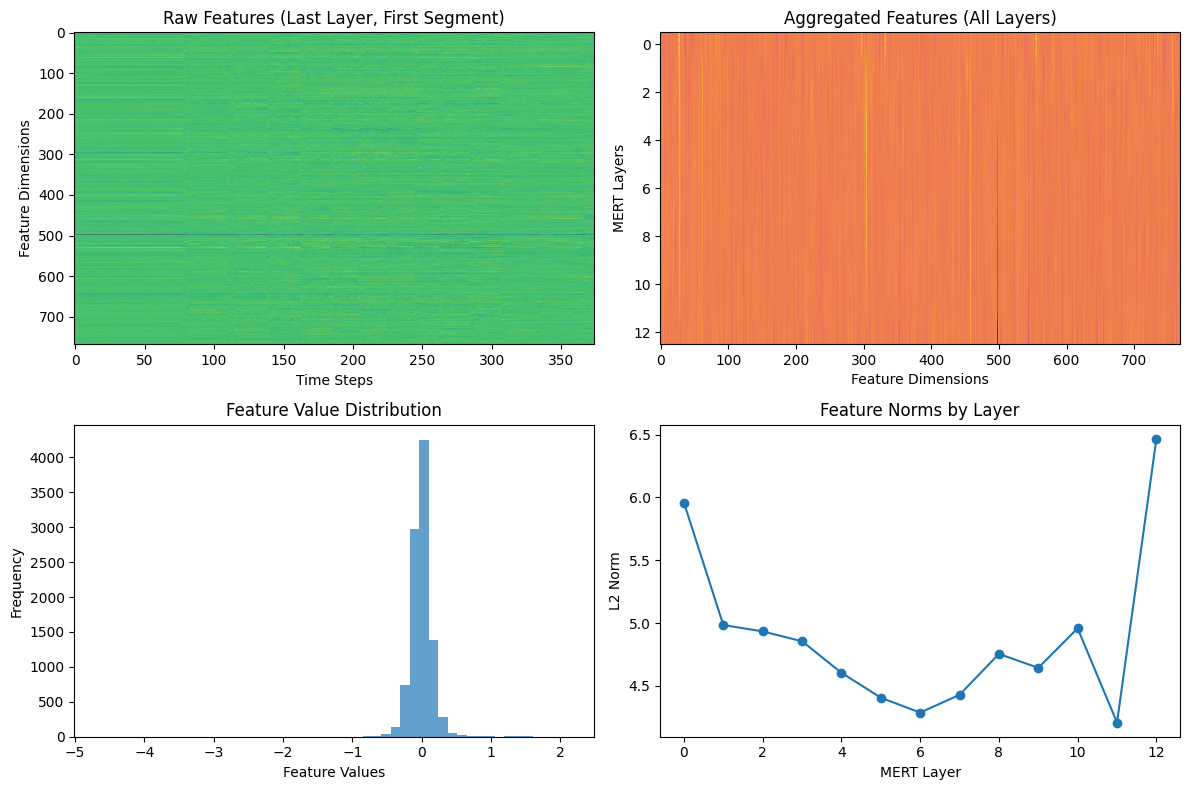

Feature value range: [-4.670, 2.147]
Feature mean: -0.001
Feature std: 0.178
Number of segments extracted: 70


In [6]:
# Visualize Feature Characteristics
if 'features' in locals():
    print("\n=== Feature Analysis ===")
    
    # Plot feature distributions
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Raw features - plot first segment, last layer
    if features['raw'].shape[0] > 0:
        sample_features = features['raw'][0, -1, :, :]  # First segment, last layer
        axes[0, 0].imshow(sample_features.T, aspect='auto', cmap='viridis')
        axes[0, 0].set_title('Raw Features (Last Layer, First Segment)')
        axes[0, 0].set_xlabel('Time Steps')
        axes[0, 0].set_ylabel('Feature Dimensions')
    
    # Aggregated features across layers
    agg_features = features['aggregated']  # Shape: [13, 768]
    axes[0, 1].imshow(agg_features, aspect='auto', cmap='plasma')
    axes[0, 1].set_title('Aggregated Features (All Layers)')
    axes[0, 1].set_xlabel('Feature Dimensions')
    axes[0, 1].set_ylabel('MERT Layers')
    
    # Feature magnitude distribution
    axes[1, 0].hist(agg_features.flatten(), bins=50, alpha=0.7)
    axes[1, 0].set_title('Feature Value Distribution')
    axes[1, 0].set_xlabel('Feature Values')
    axes[1, 0].set_ylabel('Frequency')
    
    # Layer-wise feature norms
    layer_norms = np.linalg.norm(agg_features, axis=1)
    axes[1, 1].plot(range(len(layer_norms)), layer_norms, 'o-')
    axes[1, 1].set_title('Feature Norms by Layer')
    axes[1, 1].set_xlabel('MERT Layer')
    axes[1, 1].set_ylabel('L2 Norm')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Feature value range: [{agg_features.min():.3f}, {agg_features.max():.3f}]")
    print(f"Feature mean: {agg_features.mean():.3f}")
    print(f"Feature std: {agg_features.std():.3f}")
    print(f"Number of segments extracted: {features['raw'].shape[0]}")

## Summary

This notebook tests the MERT feature extractor implementation with:

✅ **Environment validation** - Check dependencies and hardware  
✅ **Model loading** - Verify MERT model initialization  
✅ **Single file processing** - Test core extraction functionality  
✅ **Feature visualization** - Analyze output dimensions and distributions  
✅ **File I/O testing** - Verify saving and loading of features  
✅ **Batch processing** - Test multiple file handling with performance estimates

**Next steps after successful testing:**
1. Install missing dependencies if needed: `pip install transformers>=4.38`
2. Run full dataset extraction: `extract_features()` 
3. Proceed with similarity search implementation using extracted features

**Expected feature shapes:**
- Raw: `[num_segments, 13_layers, time_steps, 768]`
- Segments: `[num_segments, 13_layers, 768]` 
- Aggregated: `[13_layers, 768]`

In [7]:
# Extract Features for Full SMD Dataset
print("\n=== Full Dataset Feature Extraction ===")
print("⚠️  This will process all 50 SMD files (~2.6 minutes)")
print("💾 Storage required: ~50GB for raw features")

# Confirm before proceeding
proceed = input("Proceed with full dataset extraction? (y/n): ")

if proceed.lower() == 'y':
    try:
        print("🚀 Starting full dataset extraction...")
        start_time = time.time()
        
        # Use correct paths from notebook directory
        extractor.extract_dataset_features(
            audio_dir="../data/smd/wav-44", 
            output_dir="../data/processed/features"
        )
        
        total_time = time.time() - start_time
        print(f"✅ Full dataset extraction completed in {total_time/60:.1f} minutes")
        print(f"📁 Features saved to: ../data/processed/features/")
        
    except Exception as e:
        print(f"❌ Full dataset extraction failed: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ Full dataset extraction cancelled")


=== Full Dataset Feature Extraction ===
⚠️  This will process all 50 SMD files (~2.6 minutes)
💾 Storage required: ~50GB for raw features


KeyboardInterrupt: Interrupted by user

In [8]:
# Validate Full Dataset Feature Extraction
print("\n=== Feature Extraction Validation ===")

# Check file counts and structure
feature_dir = Path("../data/processed/features")
for feature_type in ['aggregated', 'segments', 'raw']:
    type_dir = feature_dir / feature_type
    if type_dir.exists():
        files = list(type_dir.glob("*.npy"))
        print(f"✅ {feature_type}: {len(files)} files")
    else:
        print(f"❌ {feature_type}: directory not found")

print("\n=== Feature Shape Validation ===")

# Test loading and inspecting different feature types
try:
    # Load sample features
    sample_file = "Bach_BWV849-01_001_20090916-SMD.npy"
    
    agg_features = np.load(feature_dir / "aggregated" / sample_file)
    seg_features = np.load(feature_dir / "segments" / sample_file)
    raw_features = np.load(feature_dir / "raw" / sample_file)
    
    print(f"✅ Aggregated shape: {agg_features.shape} (expected: [13, 768])")
    print(f"✅ Segments shape: {seg_features.shape} (expected: [num_segments, 13, 768])")
    print(f"✅ Raw shape: {raw_features.shape} (expected: [num_segments, 13, time_steps, 768])")
    
    # Validate feature ranges
    print(f"\n=== Feature Statistics ===")
    print(f"Aggregated - min: {agg_features.min():.3f}, max: {agg_features.max():.3f}, mean: {agg_features.mean():.3f}")
    print(f"Segments - min: {seg_features.min():.3f}, max: {seg_features.max():.3f}, mean: {seg_features.mean():.3f}")
    
    # Test consistency
    manual_agg = np.mean(seg_features, axis=0)  # Should match aggregated
    consistency = np.allclose(agg_features, manual_agg, atol=1e-6)
    print(f"✅ Aggregation consistency: {'PASSED' if consistency else 'FAILED'}")
    
except Exception as e:
    print(f"❌ Feature validation failed: {e}")
    import traceback
    traceback.print_exc()

print(f"\n=== Storage Summary ===")
print(f"📁 Features saved to: {feature_dir}")
print(f"📊 Total files: 150 (.npy files)")
print(f"💾 Estimated storage: ~94GB total")
print(f"🎯 Ready for similarity search implementation!")


=== Feature Extraction Validation ===
✅ aggregated: 50 files
✅ segments: 50 files
✅ raw: 50 files

=== Feature Shape Validation ===
✅ Aggregated shape: (13, 768) (expected: [13, 768])
✅ Segments shape: (62, 13, 768) (expected: [num_segments, 13, 768])
✅ Raw shape: (62, 13, 374, 768) (expected: [num_segments, 13, time_steps, 768])

=== Feature Statistics ===
Aggregated - min: -4.971, max: 2.105, mean: -0.002
Segments - min: -5.818, max: 2.373, mean: -0.002
✅ Aggregation consistency: PASSED

=== Storage Summary ===
📁 Features saved to: ../data/processed/features
📊 Total files: 150 (.npy files)
💾 Estimated storage: ~94GB total
🎯 Ready for similarity search implementation!
